# Facebook Social Connectedness Index 

In [107]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
import numpy as np
import itertools
from IPython.display import display, Markdown
import os
from shapely import wkt
plt.style.use('../estilos/1.mplstyle')
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

def caption(text, filename):
    display(Markdown('<p class="caption"> <em>{} (<a href="https://github.com/mauforonda/notas/raw/main/{}">imagen en alta resolución</a>) </em> </p>'.format(text, filename)))

def load_data():
    
    """
    Cargo los datos:
    
    - Facebook Social Connectedness Index: las relaciones entre regiones del nivel 1 de GADM36, 
    que pueden ser descargadas de https://data.humdata.org/dataset/social-connectedness-index 
    ( gadm1_nuts2-gadm1_nuts2 - FB Social Connectedness Index - October 2021.zip )
    
    - Definiciones del nivel 1 de GADM36, que pueden ser descargadas de 
    https://data.apps.fao.org/catalog/dataset/code-list-gadm36-global-admin-1/resource/fa5f7904-daff-4c61-a095-70c73ddbcaa7
    
    Construyo dos columnas en la tabla de GADM36:
    
    - codigo: el nombre de cada región en el Index
    - nombre: una combinación del país y región
    
    Retorna dos dataframes, uno para el Index y otro para GADM36.
    """
    
    df = pd.read_csv('data/gadm1_nuts2-gadm1_nuts2-fb-social-connectedness-index-october-2021/gadm1_nuts2_gadm1_nuts2.tsv', delimiter='\t')

    gadm = pd.read_csv('data/gadm36_1.csv')
    gadm['codigo'] = gadm.gadm36_1.apply(lambda x: x.split('_')[0].replace('.', ''))
    gadm['nombre'] = gadm[['name_0', 'name_1']].apply(lambda x: '{} - {}'.format(x[0], x[1]), axis=1)

    
    return gadm, df

def make_matrix(df, gadm, paises, self_relations=False):
    
    """
    
    Crea una matriz de adyacencias con los valores del Index de regiones 
    en una selección de países. 
    
    - df: dataframe del Facebook Social Connectedness Index
    - gadm: dataframe del GADM36
    - paises: una lista de paises
    - self_relations: decidir si retorna valores para relaciones entre 
    usuarios dentro una misma región. Por defecto no.
    
    Retorna un dataframe.
    
    """
    
    filas = gadm[gadm.name_0.str.lower().isin([p.lower() for p in paises])]
    codigos = filas['codigo'].tolist()

    relaciones = df[(df.user_loc.isin(codigos)) & (df.fr_loc.isin(codigos))]
    
    relaciones = relaciones.pivot_table(index='user_loc', columns='fr_loc', values='scaled_sci')
    relaciones.index = relaciones.index.map(filas.set_index('codigo').nombre.to_dict())
    relaciones.columns = relaciones.index
    
    if not self_relations:
        for col in relaciones.columns:
            relaciones.loc[col, col] = np.nan
            
    return relaciones

def load_geodata():
    """
    
    Carga datos geográficos de polígonos de regiones GADM36 de primer 
    nivel descargadas de https://gadm.org/download_country.html . Cada
    documento es un csv que corresponde a un país, que ha sido convertido
    desde geopackage mediante ogr2ogr.
    
    Retorna un geodataframe con datos de los polígonos y nombres de todos 
    los países disponibles
    
    """
    
    maps = pd.concat([pd.read_csv('data/gadm36_1_maps/{}'.format(i)) for i in  os.listdir('data/gadm36_1_maps/')])
    maps['WKT'] = maps.WKT.apply(wkt.loads)
    maps = gpd.GeoDataFrame(maps, geometry=maps.WKT)[['GID_1', 'geometry']]
    maps['codigo'] = maps.GID_1.apply(lambda x: x.split('_')[0].replace('.', ''))
    return maps

def plot_relaciones_region(f, ax, df, maps, dep_codigo, save=False, text_scale=1, subtitle=True):
    
    """
    Dibuja un mapa con el valor del Índice entre dep_codigo
    y el resto de regiones en maps.
    """

    departamento = gpd.GeoDataFrame(pd.concat([df[(df.user_loc == dep_codigo) & (df.fr_loc.isin(maps.codigo)) & (df.fr_loc != dep_codigo)].set_index('fr_loc'), maps.set_index('codigo')], axis=1).dropna())
    dep_nombre = gadm[gadm.codigo == dep_codigo].name_1.iloc[0]
    colormap = colors.ListedColormap(cm.get_cmap('CMRmap')(np.linspace(.05, .95, 256)))

    departamento.plot(ax=ax, column='scaled_sci', cmap=colormap, norm=colors.LogNorm(vmin=departamento.scaled_sci.min(), vmax=departamento.scaled_sci.max()), linewidth=.1, edgecolor='#f9f9f9', alpha=.8)
    ax.annotate(dep_nombre, xy=(.8, .25), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=40 * text_scale, ha='right', va='bottom', alpha=.6);
    if subtitle:
        ax.annotate('cuán probable es que\nusuarios de Facebook\nen {} y otras regiones\nsean amigos'.format(dep_nombre), xy=(.8, .245), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=14 * text_scale, ha='right', va='top', alpha=.4);
    ax.set_axis_off()
    if save:
        f.savefig('plots/Facebook_Social_Connectedness_Index_mapa_{}.png'.format(dep_nombre.replace(' ', '_')), bbox_inches='tight', pad_inches=.4, dpi=150)

El [Índice de Conectividad Social de Facebook](https://data.humdata.org/dataset/social-connectedness-index) representa la probabilidad de que usuarios en dos regiones sean amigos. Se define, para dos regiones *i* y *j*, como:

$$\frac{conexiones_{ij}}{usuarios_{i} * usuarios_{j}}$$

¿Qué patrones existen en las relaciones de usuarios dentro y entre países? ¿Estos patrones reflejan flujos migratorios, redes productivas, familias y lealtades que se extienden a través del continente? El siguiente gráfico muestra el valor del índice para cada par de regiones en Bolivia y países limítrofes. La escala de colores es logarítmica para compensar por el fuerte efecto de algunas conexiones, especialmente dentro de países. A primera vista es claro que las conexiones son más fuertes entre regiones al interior de países. Sin embargo, existe bastante heterogeneidad entre estas conexiones. ¿Existen dimensiones aparte de la proximidad geográfica que expliquen esta heterogeneidad? Son más interesantes las conexiones entre regiones de diferentes países. Como el valor del índice depende de la cantidad de usuarios en ambas regiones, resulta más sorprendente cuando se trata de regiones con alta población, como las conexiones entre departamentos de Bolivia y Santiago de Chile. 

In [3]:
# Cargo y construyo una matriz de adyacencias con los valores del índice para una serie de países

gadm, df = load_data()
matrix = make_matrix(df, gadm, ['bolivia', 'peru', 'chile', 'paraguay', 'brazil', 'argentina'])

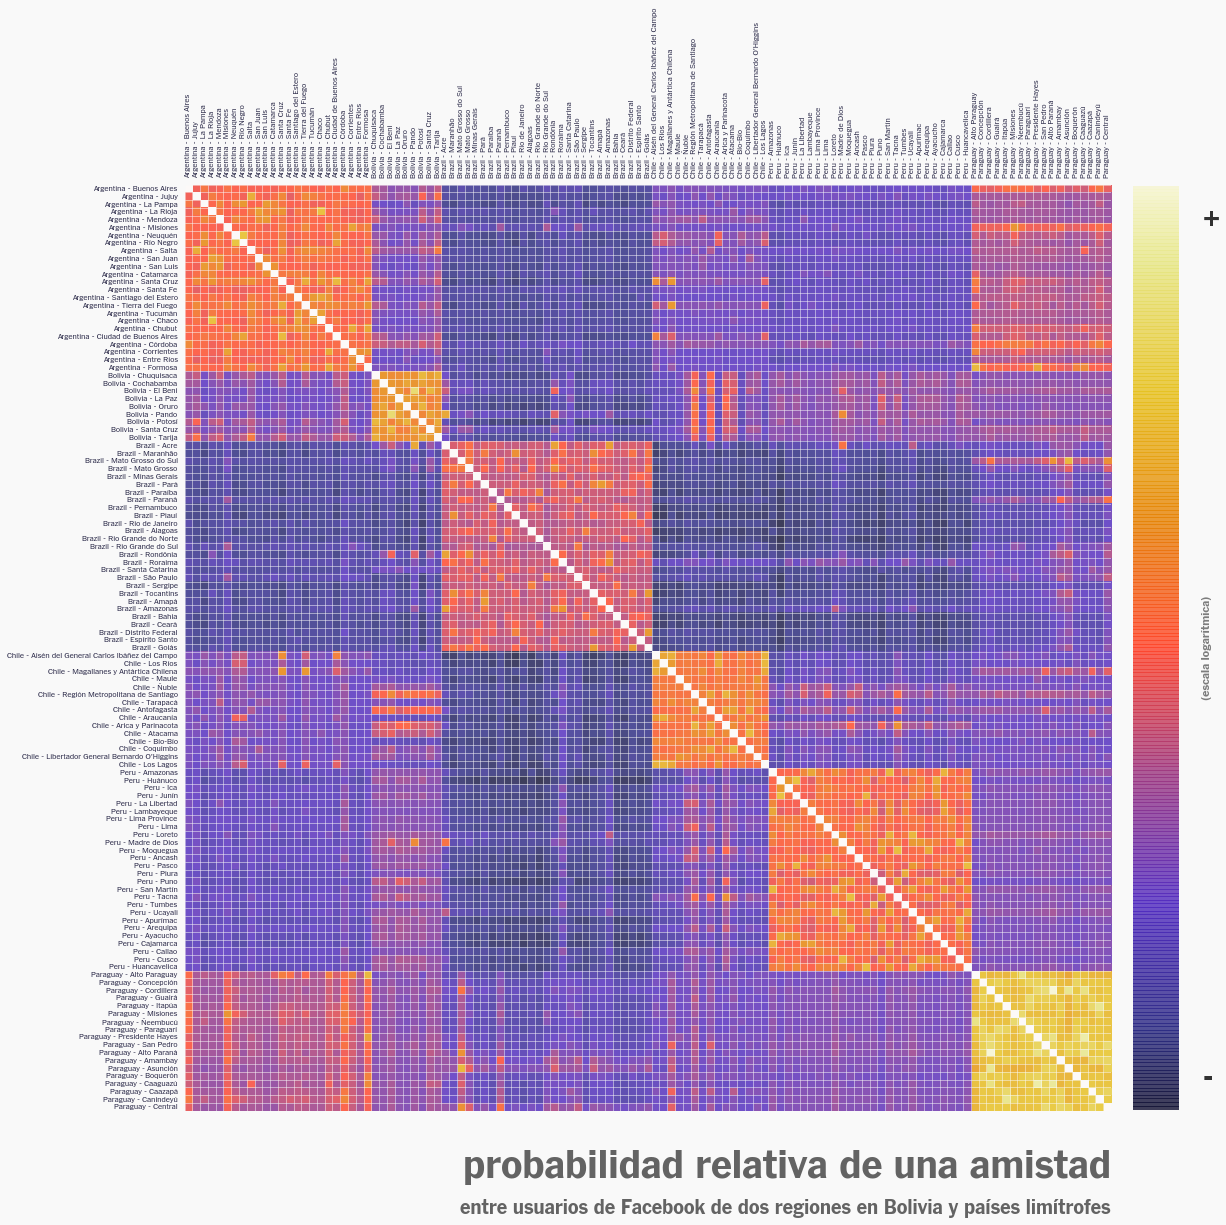

<p class="caption"> <em>probabilidad relativa de una amistad entre usuarios de Facebook de dos regiones en Bolivia y países limítrofes (<a href="https://github.com/mauforonda/notas/raw/main/plots/Facebook_Social_Connectedness_Index_matriz_latam.png">imagen en alta resolución</a>) </em> </p>

In [5]:
# Construyo un gráfico

filename = 'plots/Facebook_Social_Connectedness_Index_matriz_latam.png'
colormap = colors.ListedColormap(cm.get_cmap('CMRmap')(np.linspace(.05, .95, 256)))

f, ax  = plt.subplots(1,1,figsize=(20,20))
im = ax.imshow(matrix, cmap=colormap, norm=colors.LogNorm(vmin=matrix.min().min(), vmax=matrix.max().max()), alpha=.8)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.FixedLocator(list(range(len(matrix.columns)))))
    axis.set_major_formatter(ticker.FixedFormatter(matrix.columns));
    axis.set_minor_locator(ticker.IndexLocator(1,0))
    
ax.tick_params(labeltop=True, labelbottom=False, labelsize=8)

for label in list(itertools.chain.from_iterable([ax.get_yticklabels(), ax.get_xticklabels()])):
    label.set_color('#302f4d')
    label.set_fontfamily('NYTFranklin')
    
for label in ax.get_xticklabels():
    label.set_rotation(90)
    
ax.grid(which='minor', color='#f9f9f9', linestyle='-', linewidth=.5, alpha=1)

cbar = f.colorbar(im, shrink=.85, pad=.02)
cbar.ax.set_yticklabels([])
cbar.outline.set_linewidth(0)
cbar.ax.annotate('+', xy=(1.5, .95), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=30, ha='left', va='bottom', alpha=.8);
cbar.ax.annotate('-', xy=(1.5, .05), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=30, ha='left', va='top', alpha=.8);
cbar.ax.annotate('(escala logarítmica)', xy=(1.5, .5), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=12, ha='left', va='center', rotation=90, alpha=.5);

ax.annotate('probabilidad relativa de una amistad', xy=(1, -.08), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=40, ha='right', va='bottom', alpha=.6);
ax.annotate('entre usuarios de Facebook de dos regiones en Bolivia y países limítrofes', xy=(1, -.095), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=20, ha='right', va='top', alpha=.6);
f.savefig(filename, bbox_inches='tight', pad_inches=.4, dpi=200)
plt.show()
caption('probabilidad relativa de una amistad entre usuarios de Facebook de dos regiones en Bolivia y países limítrofes', filename)

Para ilustrar mejor la relación entre el valor del índice y la proximidad geográfica, grafico la relación entre cada departamento de Bolivia y otras regiones en Bolivia y países vecinos. El mapa de colores es similar al anterior gráfico.

In [44]:
maps = load_geodata()

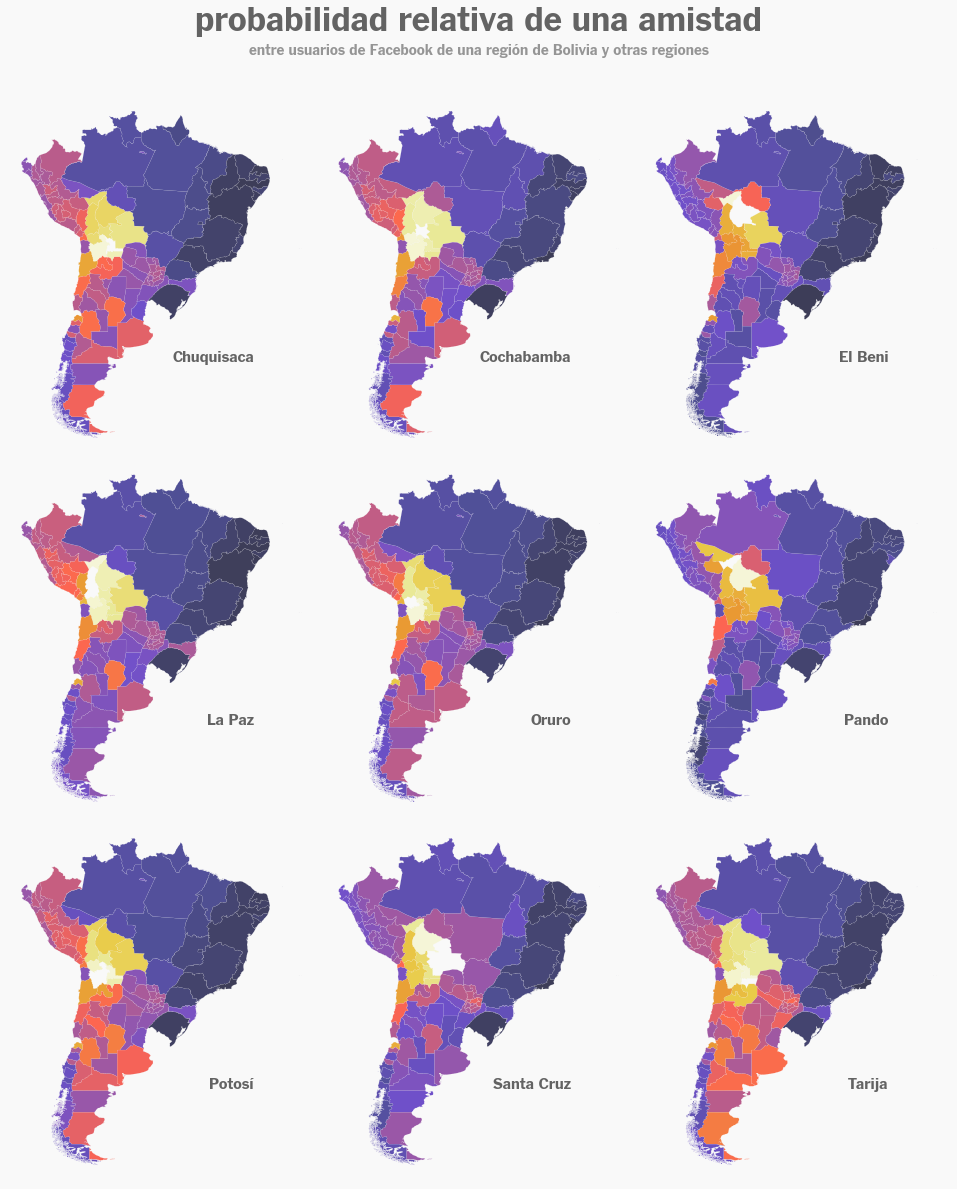

<p class="caption"> <em>probabilidad relativa de una amistad entre usuarios de Facebook de una región de Bolivia y otras regiones (<a href="https://github.com/mauforonda/notas/raw/main/plots/Facebook_Social_Connectedness_Index_mapa_Bolivia.png">imagen en alta resolución</a>) </em> </p>

In [110]:
title = ['probabilidad relativa de una amistad', 'entre usuarios de Facebook de una región de Bolivia y otras regiones']
filename = 'plots/Facebook_Social_Connectedness_Index_mapa_Bolivia.png'
f, axs = plt.subplots(3,3,figsize=(17,20))
f.set_facecolor('#f9f9f9')
plt.subplots_adjust(hspace=.01, wspace=.01)
axs = axs.flatten()
for ax, i in zip(axs, range(1,10)):
    plot_relaciones_region(f, ax, df, maps, 'BOL{}'.format(i), text_scale=.4, subtitle=False)
axs[1].annotate(title[0], xy=(.5, 1.16), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=35, ha='center', va='bottom', alpha=.6);
axs[1].annotate(title[1], xy=(.5, 1.14), xycoords='axes fraction', fontfamily='NYTFranklin', fontweight='bold', fontsize=15, ha='center', va='top', alpha=.4);
f.savefig(filename, bbox_inches='tight', pad_inches=.4, dpi=200)
plt.show()
caption(' '.join(title), filename)